# PyDeepGP tutorial

In [1]:
import numpy as np
import GPy
from pylab import *
%matplotlib inline
import os
from sys import path
np.random.seed(42)

In [2]:
# Add parent directory to path if deepgp is not there already
pwd = os.getcwd()
base_path = pwd[0:pwd.rfind(os.sep)]
path.insert(0,base_path)

In [3]:
import deepgp

In [4]:
# Utility to load sample data. It can be installed with pip. Otherwise just load some other data.
import pods

## Unsupervised learning (oil data)

In [5]:
# Load data
data = pods.datasets.oil_100()
Y = data['X']
labels =  data['Y'].argmax(axis=1)

# Number of latent dimensions per layer
Q1, Q2 = 5, 4
# Type of kernel per layer
kern1 = GPy.kern.RBF(Q1,ARD=True) + GPy.kern.Bias(Q1)
kern2 = GPy.kern.RBF(Q2,ARD=True) + GPy.kern.Bias(Q2)
# Number of inducing points per layer (can be set to different if given as list).
num_inducing = 40
# Whether to use back-constraint for variational posterior
back_constraint = False
# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [6]:
m = deepgp.DeepGP([Y.shape[1],Q1,Q2],Y,kernels=[kern1,kern2], num_inducing=num_inducing, back_constraint=back_constraint, encoder_dims = encoder_dims)

In [7]:
# Make sure initial noise variance gives a reasonable signal to noise ratio
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01

In [8]:
m.optimize(max_iters=5000, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0002   2.064426e+04   4.384230e+08 
    01s21  0029   1.529996e+02   1.709439e+03 
    03s24  0095  -3.983808e+01   2.138446e+02 
    10s36  0323  -1.555813e+02   5.527753e+01 
    31s68  0963  -2.011409e+02   1.767726e+01 
    41s77  1304  -2.066805e+02   1.288509e+01 
 01m50s96  3680  -2.117989e+02   2.915579e+00 
 02m30s02  5002  -2.128154e+02   1.023510e+00 
Runtime:  02m30s02
Optimization status: Maximum number of f evaluations reached



 /Users/damianou/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /Users/damianou/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


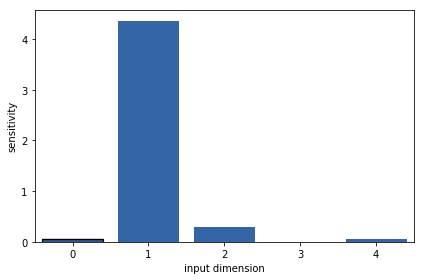

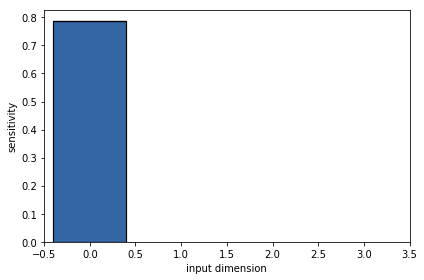

In [9]:
# Plot ARD scales per layer
m.obslayer.kern.plot_ARD()
m.layer_1.kern.plot_ARD()

Text(0.5,1,'Layer 1')

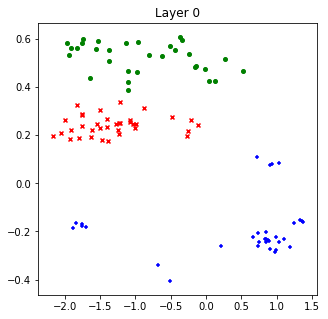

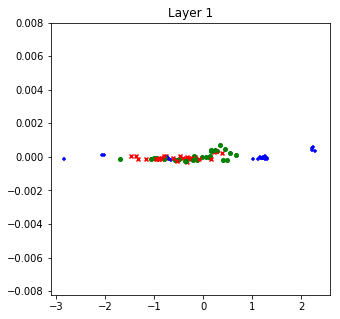

In [10]:
# From the plots above, we see which ones are the dominant dimensions for each layer. 
# So we use these dimensions in the visualization of the latent space below.
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=0, dims=[1,2]); plt.title('Layer 0')
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=1, dims=[0,1]); plt.title('Layer 1')

## Supervised learning

In [12]:
# Load some mocap data.
data = pods.datasets.cmu_mocap_35_walk_jog()

Ntr = 100
Nts = 500

# All data represented in Y_all, which is the angles of the movement of the subject
Y_all = data['Y']
perm = np.random.permutation(Ntr+Nts)
index_training = np.sort(perm[0:Ntr])
index_test     = np.sort(perm[Ntr:Ntr+Nts])

Y_all_tr = Y_all[index_training,:]
Y_all_ts = Y_all[index_test,    :]


# Some of the features (body joints) to be used as inputs, and some as outputs
X_tr = Y_all_tr[:,0:55].copy()
Y_tr = Y_all_tr[:, 55:].copy()

X_ts = Y_all_ts[:,0:55].copy()
Y_ts = Y_all_ts[:, 55:].copy()

# TODO: You might need to normalize the input and/or output data.

In [13]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 5
# Define what kernels to use per layer
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(Q,ARD=False) + GPy.kern.Bias(X_tr.shape[1])
# Number of inducing points to use
num_inducing = 40
# Whether to use back-constraint for variational posterior
back_constraint = False
# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [14]:
m = deepgp.DeepGP([Y_tr.shape[1],Q,X_tr.shape[1]],Y_tr, X_tr=X_tr,kernels=[kern1, kern2], num_inducing=num_inducing, back_constraint=back_constraint)

In [15]:
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01
    m.layers[i].Gaussian_noise.variance.fix()

In [16]:
print(m)


Name : deepgp
Objective : 30593.926415878646
Number of Parameters : 14492
Number of Optimization Parameters : 14490
Updates : True
Parameters:
  deepgp.                           |            value  |  constraints  |  priors
  obslayer.inducing_inputs          |          (40, 5)  |               |        
  obslayer.sum.rbf.variance         |              1.0  |      +ve      |        
  obslayer.sum.rbf.lengthscale      |             (5,)  |      +ve      |        
  obslayer.sum.bias.variance        |              1.0  |      +ve      |        
  obslayer.Gaussian_noise.variance  |     2.0880093987  |   +ve fixed   |        
  obslayer.Kuu_var                  |            (40,)  |      +ve      |        
  obslayer.latent_space.mean        |         (100, 5)  |               |        
  obslayer.latent_space.variance    |         (100, 5)  |      +ve      |        
  layer_1.inducing_inputs           |         (40, 55)  |               |        
  layer_1.sum.rbf.variance          

In [17]:
m.optimize(max_iters=800, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s18  002   1.860136e+04   4.117141e+07 
    02s23  074   2.797014e+03   1.154973e+04 
    05s27  165   1.733137e+03   3.477689e+03 
    09s37  267   1.515610e+03   4.827671e+02 
    27s42  802   1.406545e+03   7.517189e+01 
Runtime:     27s42
Optimization status: Maximum number of f evaluations reached



In [18]:
# Unfix noise variance now that we have initialized the model
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()

In [19]:
m.optimize(max_iters=1500, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0002   1.364995e+03   1.499064e+05 
    02s20  0074   1.286412e+03   1.839595e+03 
    10s52  0291   1.270322e+03   2.907255e+01 
    14s60  0419   1.269333e+03   1.795171e+01 
    41s02  1251   1.267812e+03   5.261620e+00 
    47s96  1502   1.267683e+03   2.312637e+00 
Runtime:     47s96
Optimization status: Maximum number of f evaluations reached



### Compare with GP

In [20]:
m_GP = GPy.models.SparseGPRegression(X=X_tr, Y=Y_tr, kernel=GPy.kern.RBF(X_tr.shape[1])+GPy.kern.Bias(X_tr.shape[1]), num_inducing=num_inducing)

In [21]:
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100, messages=True)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s09  006   2.707449e+03   4.809828e+02 
    00s18  012   2.605810e+03   1.328432e+00 
    00s31  028   2.589843e+03   1.917063e-06 
Runtime:     00s31
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s01  001   2.589843e+03   2.071726e+05 
    00s16  010   1.851023e+03   3.268182e-01 
    00s19  013   1.850593e+03   2.237858e-02 
    00s34  031   1.850513e+03   1.120716e-05 
Runtime:     00s34
Optimization status: Converged



In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.flatten() - targets.flatten()) ** 2).mean())


In [23]:
Y_pred = m.predict(X_ts)[0]
Y_pred_s = m.predict_withSamples(X_ts, nSamples=500)[0]
Y_pred_GP = m_GP.predict(X_ts)[0]

print('# RMSE DGP               : ' + str(rmse(Y_pred, Y_ts)))
print('# RMSE DGP (with samples): ' + str(rmse(Y_pred_s, Y_ts)))
print('# RMSE GP                : ' + str(rmse(Y_pred_GP, Y_ts)))

# RMSE DGP               : 3.01217988444
# RMSE DGP (with samples): 3.01546206794
# RMSE GP                : 3.01577857739
